In [ ]:
!pip install --upgrade matplotlib > None # need refresh enviroment after installation

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
!pip install basemap > None

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats
from mpl_toolkits.basemap import Basemap

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, classification_report, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
%matplotlib inline

# Data intro

Я буду использовать набор данных социально-экономических показателей крупных городов России.

Набор содержит сведения по 70 базовым социально-экономическим показателям для более 200 крупных российских городов за 1985-2019 гг. из ежегодных статистических сборниках Росстата.

Данные взяты из платформы ИНИД
(https://data.rcsi.science/data-catalog/datasets/187/)

Из особенностей - нет Москвы и Петербурга, возможно из-за их федерального статуса, поэтому они могут не учитываться едино в Базе данных муниципальных образований

In [ ]:
path = 'data.csv'
data = pd.read_csv(path, delimiter = ';')
data.head()

,region,municipality,settlement,oktmo,latitude_dd,longitude_dd,year,assets,assets_depreciation,assets_exhausted,...,retail_growth,rni,schools,servises,volume_electr,volume_manufact,volume_mining,volume_water,wage,workers
0,Алтайский край,Барнаул,Барнаул,1701000001,53.348056,83.78,1985,NaN,NaN,NaN,...,NaN,6.6,91.0,0.147,NaN,NaN,NaN,NaN,0.213,353.8
1,Алтайский край,Барнаул,Барнаул,1701000001,53.348056,83.78,1990,NaN,NaN,NaN,...,NaN,2.9,99.0,0.208,NaN,NaN,NaN,NaN,0.296,336.7
2,Алтайский край,Барнаул,Барнаул,1701000001,53.348056,83.78,1995,NaN,NaN,NaN,...,NaN,-6.1,107.0,432.600,NaN,NaN,NaN,NaN,440.000,269.5
3,Алтайский край,Барнаул,Барнаул,1701000001,53.348056,83.78,1996,NaN,NaN,NaN,...,NaN,-6.2,107.0,694.600,NaN,NaN,NaN,NaN,756.500,262.8
4,Алтайский край,Барнаул,Барнаул,1701000001,53.348056,83.78,1997,NaN,NaN,NaN,...,NaN,-4.9,108.0,1035.400,NaN,NaN,NaN,NaN,889.900,257.6


In [ ]:
data.dtypes

region              object
municipality        object
settlement          object
oktmo                int64
latitude_dd        float64
                    ...   
volume_manufact    float64
volume_mining      float64
volume_water       float64
wage               float64
workers            float64
Length: 77, dtype: object

Временной период и количество показателей кажется большим на первый взгляд, но!

Данные о городах очень фрагментированы, содержат как отдельные пропуски по годам, так и по отдельным показателям (разные показатели собирались в 90-ые, 00-ые и сейчас). Исследование временных рядов по данным (вне этой домашки) оказалось затруднительным, потому что в средних городах данные собирались не каждый год.
Поэтому свои задачи я сформулирую так:
1.   найти наиболее полный год для исследования, включающий наибольшее количество городов,
2.   отбросить неполные показатели
3. рассмотреть оставшиеся показатели, выбрать целевой (который может быть связан с другими)
4. выбрать метрику после EDA
5. построить и оценить качество бейзлайна - будет интересно найти хоть какие-то взаимосвязи для таких глобальных данных

Работа будет связана с моделями регрессии, буду выбирать среди метрик для неё

Исследуем наличие NaN значений во временных промежутках:

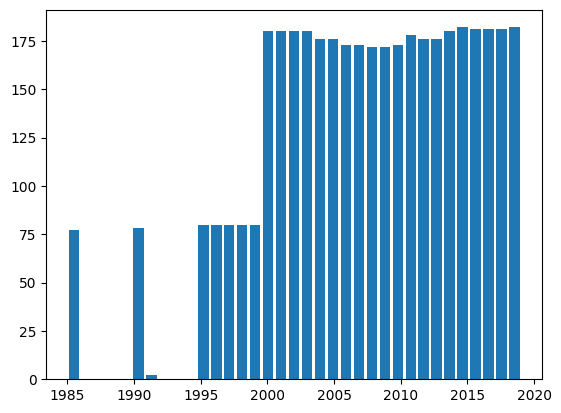

In [ ]:
plt.hist(data['year'],bins = 35,rwidth = 0.8)
plt.show()

Количество записей городов с 2000 года держится примерно на одном уровне. Возьмём самые поздние и актуальные данные - за 2019 год. Рассмотрим, сколько показателей сохраняется в городах:

In [ ]:
grouped_by_year = data.groupby('year')
result_df = pd.DataFrame()

for year, group in grouped_by_year:
    percentages = group.apply(lambda x: x.count() / len(x) * 100)
    result_df = pd.concat([result_df, percentages], axis=1, ignore_index=True)

result_df.columns = grouped_by_year.groups.keys()
pokaz_2019 = result_df[2019]

In [ ]:
ok = pokaz_2019 [pokaz_2019 == 100].index
len(ok)

24

Получилось 24 столбца - с вычетом географической информации и года (7 столбцов) получается 17 показателей.

In [ ]:
clean = data[data['year']==2019]
clean = clean[ok]
clean.head()

,region,municipality,settlement,oktmo,latitude_dd,longitude_dd,year,assets,assets_depreciation,assets_new,...,n_companies,pop_1_6,pop_work,pop_young,population,preschool_child,preschool_places,rni,wage,workers
26,Алтайский край,Барнаул,Барнаул,1701000001,53.348056,83.780000,2019,430407.3,52.4,29633.6,...,29412.0,51.5,410.2,124.2,697.0,35.1,36.4,-1.6,37855.1,157.2
46,Алтайский край,Бийск,Бийск,1705000001,52.539167,85.213889,2019,42882.7,53.1,2593.7,...,4438.0,14.9,116.0,38.8,209.2,9.2,8.9,-6.1,30203.9,41.0
66,Алтайский край,Рубцовск,Рубцовск,1716000001,51.501111,81.207778,2019,20347.9,58.6,2288.7,...,1570.0,8.6,80.1,23.5,141.6,5.7,6.3,-7.5,29941.9,25.6
93,Краснодарский край,Город Краснодар,Краснодар,3701000001,45.040278,38.976111,2019,2577374.9,45.2,165367.3,...,49124.0,88.2,591.9,195.5,1022.0,67.6,67.2,4.0,49353.6,292.3
113,Краснодарский край,Город Армавир,Армавир,3705000001,45.001111,41.132500,2019,27989.3,54.8,1619.8,...,2803.0,12.8,120.7,33.1,207.6,8.8,7.9,-2.3,30857.3,32.2


In [ ]:
clean.dtypes

region                  object
municipality            object
settlement              object
oktmo                    int64
latitude_dd            float64
longitude_dd           float64
year                     int64
assets                 float64
assets_depreciation    float64
assets_new             float64
birth                  float64
death                  float64
living_space           float64
migration              float64
n_companies            float64
pop_1_6                float64
pop_work               float64
pop_young              float64
population             float64
preschool_child        float64
preschool_places       float64
rni                    float64
wage                   float64
workers                float64
dtype: object

Все 17 показателей типа float, а это значит, мне не нужно разбираться с категориальными переменными, ура!

Социально-экономические географы понимают и без матриц корреляций, что абсолютные показатели (посчитанные на город), очень тесно будут связаны с его численностью населения (это и численность отдельных групп населения, количество новых дошкольных мест). Но чтобы выявить все показатели с такой корреляцией, матрицей всё же воспользуемся:

In [ ]:
corr_matrix = clean.corr()
def pokaz_corr(i):
  corr_values = corr_matrix[abs(corr_matrix) >= i].stack().reset_index()
  corr_values.columns = ['Variable 1', 'Variable 2', 'Correlation']
  high_corr_values = corr_values[(abs(corr_values['Correlation']) >= i)&(abs(corr_values['Correlation']) < 1)]
  return high_corr_values.sort_values(by = 'Correlation')[::2]

irr = pokaz_corr(0.7)
irr

,Variable 1,Variable 2,Correlation
18,death,rni,-0.889404
14,assets_new,workers,0.723363
6,assets,pop_1_6,0.723533
42,pop_young,assets,0.740853
7,assets,pop_work,0.746907
9,assets,population,0.747315
5,assets,n_companies,0.750090
10,assets,workers,0.786783
4,assets,assets_new,0.824304
16,birth,rni,0.825182


Показатель численности населения хочется оставить - рассмотреть влияние агломерационного эффекта, поэтому другие абсолютные показатели с сильной корреляцией я переведу в относительные.
Также можно заметить связь показателя естественного прироста  (rni) со смертностью (что логично, второе компонент первого), а также количества мест (preschool_places) и детей (preschool_child). Для каждой из пар выберем наиболее релевантный показатель, а другой исключим

In [ ]:
clean1 = clean.drop(['rni','preschool_child'],axis=1)
clean1['workers'] = clean['workers'] / clean['pop_work'] * 100
clean1['pop_work'] = clean['pop_work'] / clean['population'] * 100
clean1['pop_young'] = clean['pop_young'] / clean['population'] * 100
clean1['pop_1_6'] = clean['pop_1_6'] / clean['population'] * 100
clean1['n_companies'] = clean['n_companies'] / clean['population']
clean1['assets'] = clean['assets'] / clean['population']
clean1['assets_new'] = clean['assets_new'] / clean['assets'] * 100
clean1['preschool_places'] = clean['preschool_places'] / clean['population']

Не все показатели были расчитаны относительно численности населения:

workers из среднегодовой численности работников организаций превратился в показатель трудоустроенности (посколько расчитан из численности рабочего населения в городе)

assets_new показывает не ввод основных фондов за год в городе, а их прирост к общему количеству фондов (теперь тоже относительный показатель)

In [ ]:
corr_matrix = clean1.corr()
irr = pokaz_corr(0.5)
irr

,Variable 1,Variable 2,Correlation
11,death,pop_young,-0.644647
17,pop_1_6,pop_work,-0.632617
10,death,pop_work,-0.624519
15,n_companies,population,0.526328
2,latitude_dd,wage,0.544749
8,birth,pop_young,0.791451


Теперь ситуация намного лучше! Нет корреляций сильнее 0.8, а большая часть корреляций средней силы связана с демографическими показателями, которые связаны, но отражают разную ситуацию:
(доля молодого населения отражает более длительный период фертильности населения, чем рождаемость
высокая доля работоспособного населения может показывать не только низкую смертность, но и отсутствие сдвига среднего возраста населения)

In [ ]:
clean1['settlement'].count()

182

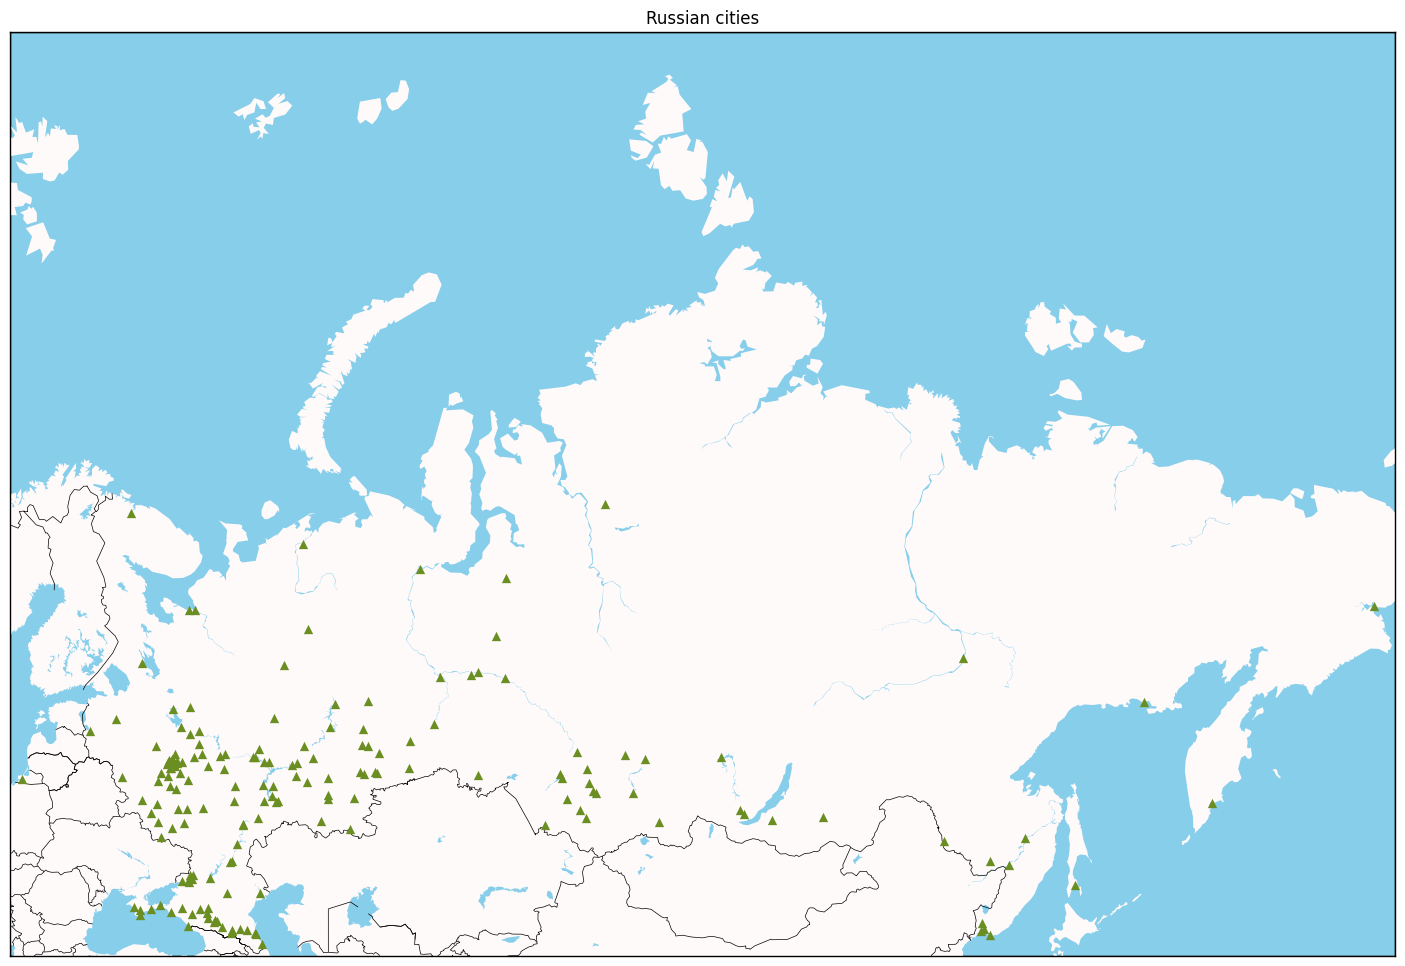

In [ ]:
plt.figure(1, figsize=(20,12))

# Mercator of World
m1 = Basemap(
    projection='merc',
    llcrnrlat=41,  # минимальная широта (юг)
    urcrnrlat=82,  # максимальная широта (север)
    llcrnrlon=19,  # минимальная долгота (запад)
    urcrnrlon=180,  # максимальная долгота (восток)
    lat_0=61,  # центральная широта
    lon_0=100,  # центральная долгота
    lat_ts=0,
    resolution='l',
)

m1.fillcontinents(color='#FFFAFA',lake_color='#87CEEB') # dark grey land, black lakes
m1.drawmapboundary(fill_color='#87CEEB')                # black background
m1.drawcountries(linewidth=0.5, color="#000000")        # thin white line for country borders


xxy = m1(clean1["longitude_dd"].tolist(), clean1["latitude_dd"].tolist())
m1.scatter(xxy[0], xxy[1], s=45, c="#6B8E23", lw=0, alpha=1, zorder=2, marker = '^')

plt.title("Russian cities")
plt.savefig('map.png', dpi=100)
plt.show()

Представлены города всех федеральных округов и экономических районов страны. Кажущиеся облака плотности в Московской области и на Кавказе лишь повторяет наличие там большого количества городов. В теории, дальнейшие алгоритмы могут подойти для любого другого российского города.

In [ ]:
clean1.dtypes

region                  object
municipality            object
settlement              object
oktmo                    int64
latitude_dd            float64
longitude_dd           float64
year                     int64
assets                 float64
assets_depreciation    float64
assets_new             float64
birth                  float64
death                  float64
living_space           float64
migration              float64
n_companies            float64
pop_1_6                float64
pop_work               float64
pop_young              float64
population             float64
preschool_places       float64
wage                   float64
workers                float64
dtype: object

In [ ]:
data_clean = clean1.drop(['region','municipality','settlement','oktmo','latitude_dd','longitude_dd','year'],axis = 1)

Подготовимся к анализу значений показателей. Полученные 15 показателей:
1. assets - Наличие основных фондов организаций на тысячу человек; (на конец года), млн. руб.
2. assets_depreciation - Степень износа основных фондов (на конец года), %
3. assets_new - Ввод в действие основных фондов, % к основным фондам
4. birth 	- Число родившихся на 1000 человек населения
5. death 	- Число умерших на 1000 человек населения
6. living_space - Общая площадь жилых помещений, приходящаяся в среднем на одного городского жителя (на конец года), м2
7. migration 	- Миграционный прирост населения, человек
8. n_companies 	- Число предприятий и организаций (на конец года)
9. pop_1_6 	- Доля детей в возрасте 1-6 лет в населении, %
10. pop_work - Доля людей в трудоспособном возрасте в населении, %
11. pop_young - Доля людей моложе трудоспособного возраста в населении, %
12. population - Численность населения, в тыс. человек
13. preschool_places - количество мест для детей дошкольного возраста на тысячу человек
14. wage - Среднемесячная номинальная начисленная заработная плата, руб.
15. workers - Доля среднегодовой численности работников организаций к численности населения в трудоспособном возрасте, %

In [ ]:
data_clean

,assets,assets_depreciation,assets_new,birth,death,living_space,migration,n_companies,pop_1_6,pop_work,pop_young,population,preschool_places,wage,workers
26,617.514060,52.4,6.885013,9.8,11.4,25.2,1350.0,42.197991,7.388809,58.852224,17.819225,697.0,0.052224,37855.1,38.322769
46,204.984226,53.1,6.048360,8.9,15.0,21.2,171.0,21.214149,7.122371,55.449331,18.546845,209.2,0.042543,30203.9,35.344828
66,143.699859,58.6,11.247844,7.2,14.7,20.9,100.0,11.087571,6.073446,56.567797,16.596045,141.6,0.044492,29941.9,31.960050
93,2521.893249,45.2,6.416114,15.0,11.0,36.4,10055.0,48.066536,8.630137,57.915851,19.129159,1022.0,0.065753,49353.6,49.383342
113,134.823218,54.8,5.787212,8.6,10.9,22.8,-768.0,13.501927,6.165703,58.140655,15.944123,207.6,0.038054,30857.3,26.677713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4005,1210.033872,55.0,8.984822,21.6,4.6,27.4,-508.0,17.063393,12.834058,59.260410,30.950901,321.8,0.047545,35921.0,43.261668
4032,401.137571,54.5,8.907702,10.3,8.6,24.7,1380.0,29.006101,8.797481,58.649872,20.724267,508.1,0.069475,36009.7,41.778523
4052,543.482353,39.7,10.046036,9.4,10.0,22.0,504.0,12.996078,7.843137,56.156863,20.313725,127.5,0.077647,31404.8,28.491620
4081,1688.039628,45.5,7.945465,13.9,5.8,21.4,1617.0,40.643963,9.287926,62.848297,23.065015,323.0,0.052257,77130.3,41.625616


In [ ]:
data_clean.describe()

,assets,assets_depreciation,assets_new,birth,death,living_space,migration,n_companies,pop_1_6,pop_work,pop_young,population,preschool_places,wage,workers
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,1120.472875,49.202747,8.120748,10.333516,11.423077,26.031319,1002.950549,26.859758,7.712262,57.644939,18.954496,329.617582,0.053677,47940.241758,44.224977
std,1648.785445,10.412336,4.784428,2.450736,3.031495,5.477615,3000.905669,12.680255,1.207013,2.906885,2.687830,305.929494,0.012602,17954.318809,13.518832
min,26.523777,20.400000,0.239112,4.600000,0.800000,14.500000,-7732.000000,5.431520,5.440901,51.741294,13.861751,12.200000,0.021615,25418.300000,13.427110
25%,411.835357,41.950000,5.329531,8.900000,10.100000,23.700000,-424.750000,16.794757,6.836846,55.682254,16.933426,126.025000,0.044981,36334.375000,37.137793
50%,691.612834,50.150000,6.848114,9.800000,11.700000,25.450000,350.000000,24.308796,7.512098,57.283249,18.623053,219.250000,0.053464,42550.100000,43.548590
75%,1274.850801,55.775000,9.895479,11.275000,13.500000,28.150000,1587.750000,35.655826,8.406219,58.848930,20.125428,411.125000,0.061501,51947.775000,49.884619
max,13519.488534,97.900000,31.426347,21.600000,17.200000,69.000000,15896.000000,71.934266,12.834058,68.328767,30.950901,1625.600000,0.097497,123898.000000,128.169014


Из-за перевода большей части показателей в относительные, большая часть значений таблицы находится в пределах [0-100], однако assets, wage имеют другую размерность - для модели нужно будет это учесть. Целевым показателем я решил выбрать среднюю заработную плату - показатель, отражающий общее благосостояние города, который в теории может зависеть от большого количества факторов (в том числе из нашего набора данных)

**target: wage (Среднемесячная номинальная начисленная заработная плата, руб.)**

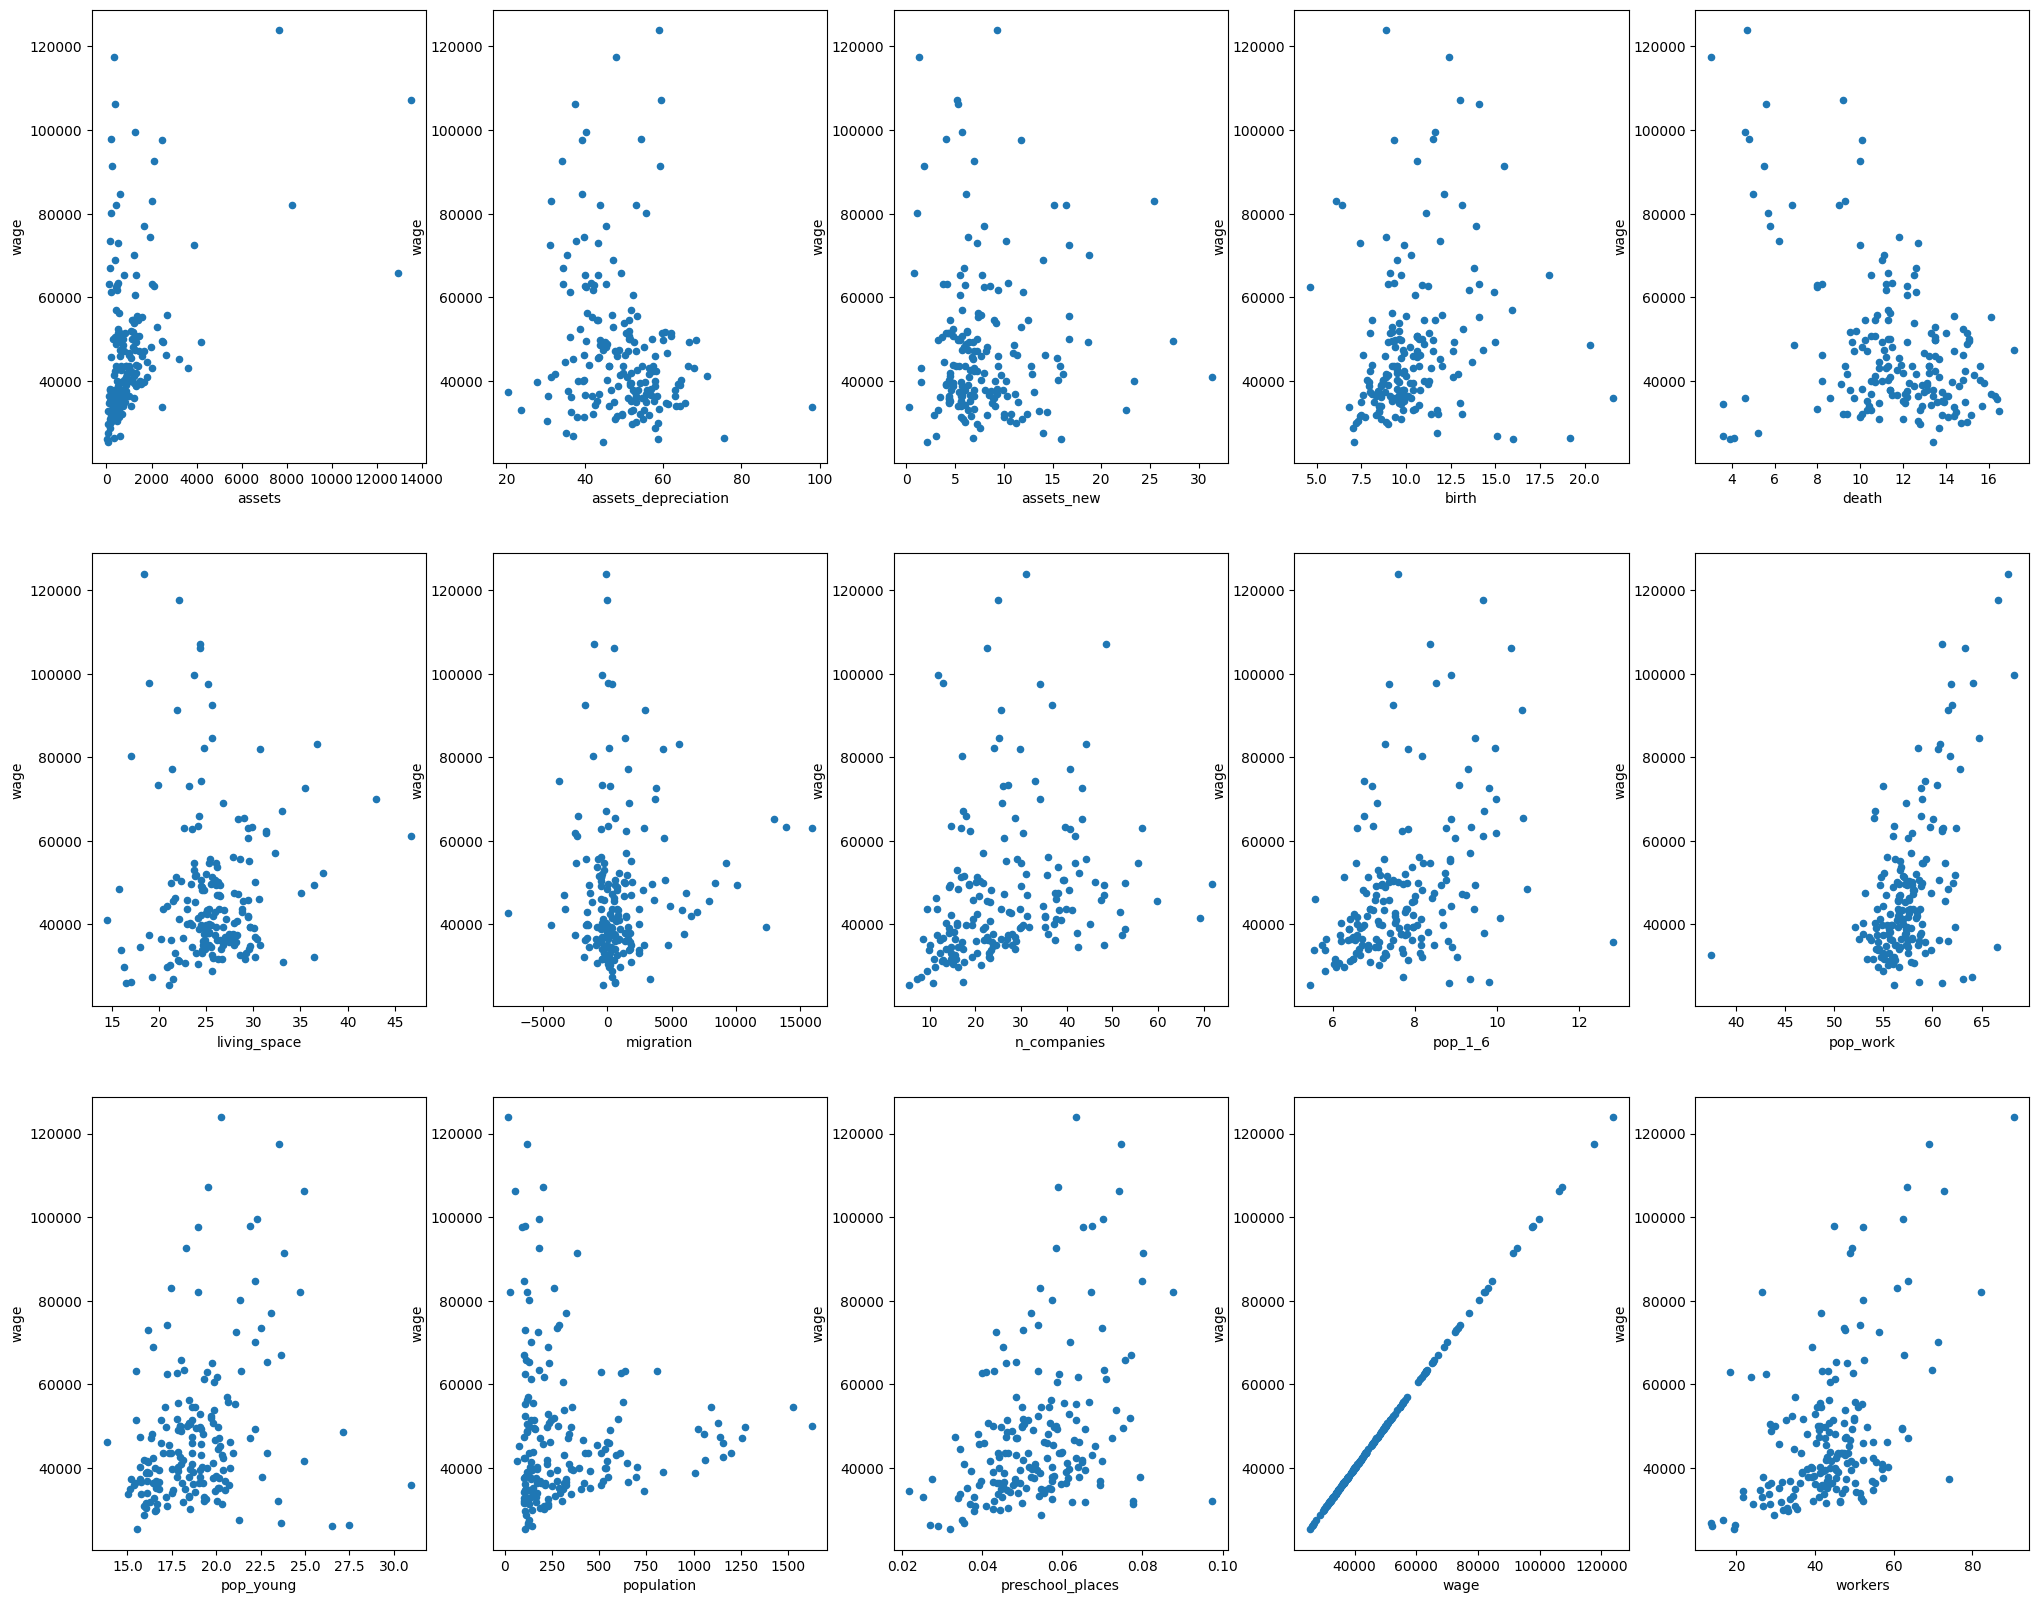

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 20))
for idx, feature in enumerate(data_clean.columns):
    data_clean.plot(feature, "wage", subplots=True, kind="scatter", ax=axes[idx // 5, idx % 5])

Можно увидеть возможные линейные зависимости средней зарплаты в городе с долей рабочего населения в городе (pop_work), а также с долей трудоустроенного населения (workers). Если связь со вторым признаком логична, то связь с первым может указывать на то, что среднюю зарплату считали именно на общее население города, а не на рабочее (лично моё предположение).

Также можно заметить выбросы во многих показателях - многие из них связаны с разнообразием городов страны, отсутствием единой специфики. Но выбивающиеся ситуации можно заметить сразу:

In [ ]:
print(clean1[clean1['living_space'] > 65]['settlement'])
print(clean1[clean1['pop_1_6'] > 40]['settlement'])
print(clean1[clean1['preschool_places'] > 40]['settlement'])
print(clean1[clean1['workers'] > 90]['settlement'])
print(clean1[clean1['workers'] > 100]['settlement'])

1063    Магас
Name: settlement, dtype: object
1423    Феодосия
1429        Ялта
Name: settlement, dtype: object
831       Вологда
851     Череповец
878       Воронеж
999       Иркутск
1019      Ангарск
1039       Братск
4081       Якутск
Name: settlement, dtype: object
1063      Магас
3248    Анадырь
Name: settlement, dtype: object
1063    Магас
Name: settlement, dtype: object


Высокая доля площадей на человека в Магасе - проблема статистики республик Кавказа, реальный показатель мы не посчитаем

Высокая доля детей в Феодосии и Ялте - анализ временных рядов показал, что в таблице были перепутан показатель численности детей и взрослого населения

Гигантское количество дошкольных мест в городах - проблема, скорее всего, в том, что власти записывали показатель не в тысячах мест - поправим размерность

Высокая доля трудоустроенных - в Анадыре это нормальная ситуация (что там ещё делать, кроме работы), но вот в Магасе этот показатель уже больше 100.

Магас пугает меня своей статистикой, выкинем его из нашей выборки

In [ ]:
data_clean = data_clean.drop(index=1063) #убираем Магас
preschool = data_clean[data_clean['preschool_places'] > 40]['preschool_places'].index
for i in preschool:
  data_clean['preschool_places'][i] = data_clean['preschool_places'][i] / 1000
  print( data_clean['preschool_places'][i])

In [ ]:
data_clean['pop_work'][1423] = 52 / 139.1 * 100
data_clean['pop_work'][1429] = 76.4 / 139.1 * 100
data_clean['pop_1_6'][1423] = 6.7 / 100.6 * 100
data_clean['pop_1_6'][1429] = 8.6 / 139.1 * 100

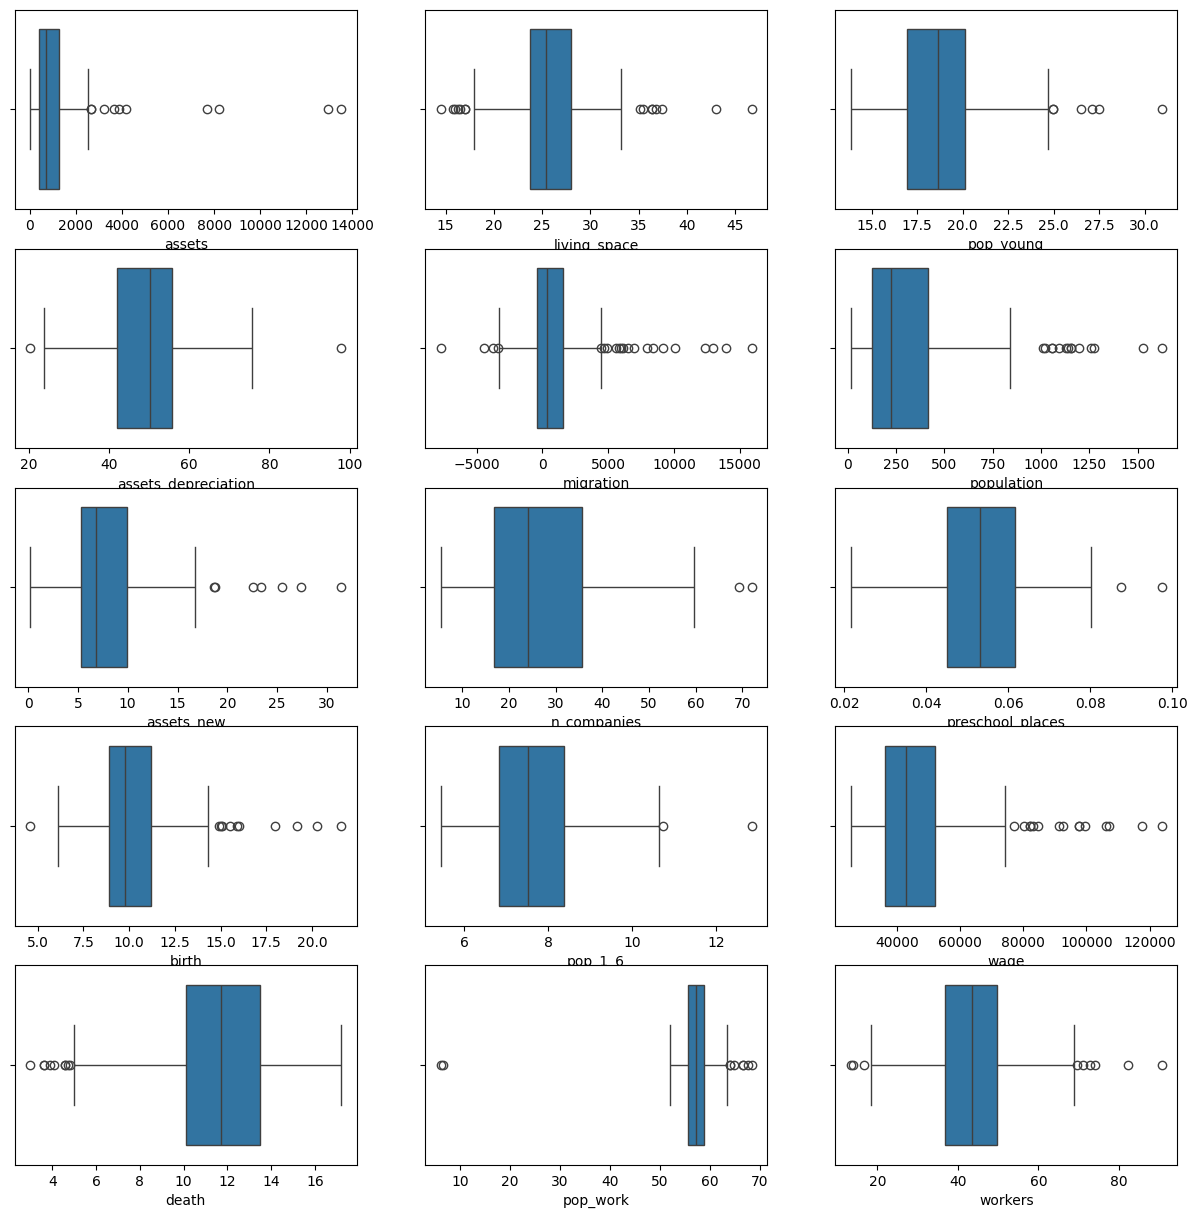

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
count = 0
for idx, feature in enumerate(data_clean.columns):
    sns.boxplot(x=data_clean[feature], ax=axes[count % 5, count // 5])
    count += 1

Боксплоты показывают выбросы, но их уже меньше

Метрик для измерения качества будет использоваться несколько. Так как набор городских данных довольно специфичный и не содержит показатели, непосредственно вляющие на среднюю зарплату в городе, будет интересно в целом оценить возможную степень зависимости параметров - поэтому для начала оценка будет производиться через R^2
Уже сейчас можно сказать, что некоторые группы городов сильно отличаются, поэтому будут наблюдаться выбросы в отдельных показателях (например, города Кавказа с более высокой рождаемостью, долей детей) - поэтому вторым показателем будет RMSE

Разобьём выборку на тестовую и тренировочную, стандартизируем показатели:

In [155]:
X_train, X_test, y_train, y_test = train_test_split(
    data_clean.drop(columns='wage'),
    data_clean['wage'],
    random_state=2024,
    test_size=0.20
)

In [156]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [157]:
X_train_scaled.mean()

assets                -1.665335e-16
assets_depreciation    1.572816e-16
assets_new            -2.405483e-16
birth                 -6.167906e-17
death                  5.551115e-17
living_space           3.700743e-17
migration              2.467162e-17
n_companies            3.700743e-17
pop_1_6                4.656769e-16
pop_work               1.233581e-15
pop_young             -5.366078e-16
population             4.934325e-17
preschool_places       9.560254e-17
workers                3.330669e-16
dtype: float64

In [158]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)

dummy = DummyRegressor(strategy='median')
dummy.fit(X_train, y_train)
y_preds_dummy = dummy.predict(X_test)

print(f'RMSE for Linear regression: {mean_squared_error(y_test, y_preds_lr, squared=False)}')
print(f'R2 score for Linear regression: {r2_score(y_test, y_preds_lr)}')
print(f'RMSE for Dummy: {mean_squared_error(y_test, y_preds_dummy, squared=False)}')
print(f'R2 score for Dummy: {r2_score(y_test, y_preds_dummy)}')

RMSE for Linear regression: 10715.163860528024
R2 score for Linear regression: 0.7662315499754184
RMSE for Dummy: 24160.768680909816
R2 score for Dummy: -0.1885289327326407


Видим заметную разницу по обоим показателям, однако в процентном соотношении между моделями она гораздо меньше для RMSE - что, думаю, также объясняется выбросами. Корреляция средней силы выявлена.

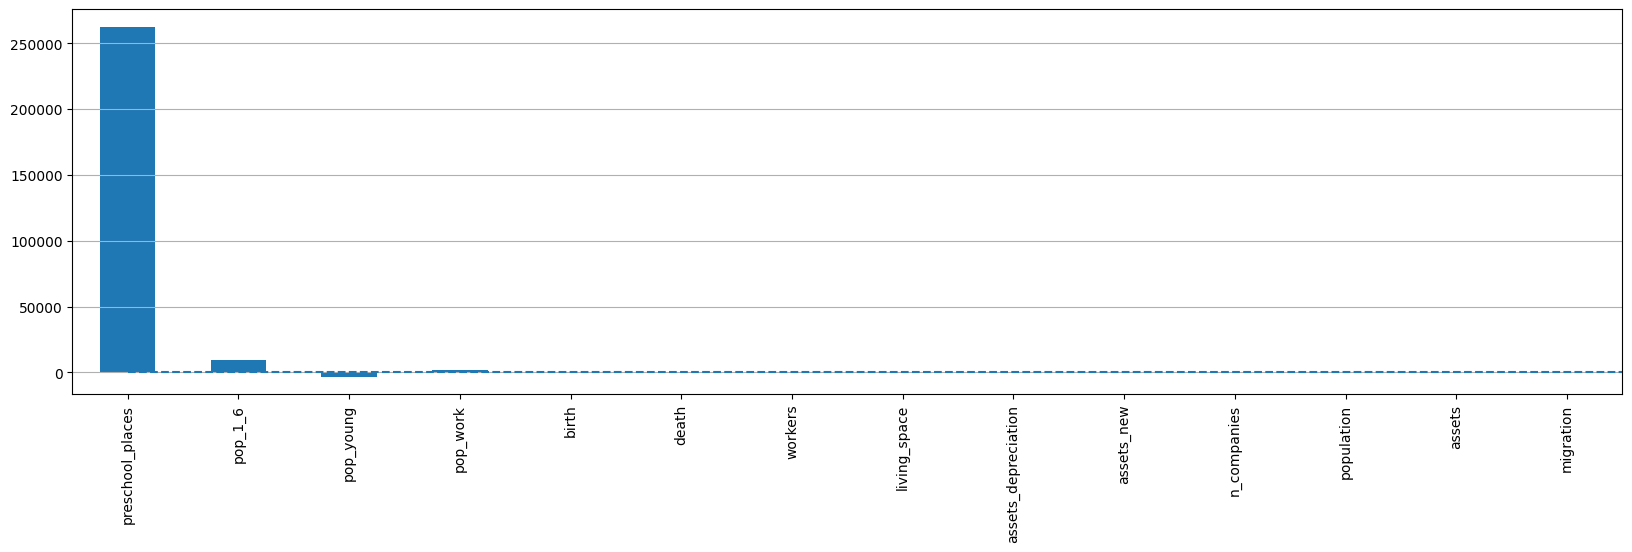

In [159]:
def plotCoefficients(model, columns):
    coefs = pd.DataFrame(model.coef_, columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)

    plt.figure(figsize=(20, 5))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
plotCoefficients(lr, X_train_scaled.columns)

# Визуализация PCA

In [ ]:
model = PCA(n_components=2)
model.fit(df_scaled)
pca_coords = model.transform(df_scaled)

In [ ]:
df_to_draw = pd.DataFrame({

    'pca1': pca_coords[:, 0],
    'pca2': pca_coords[:, 1],
})

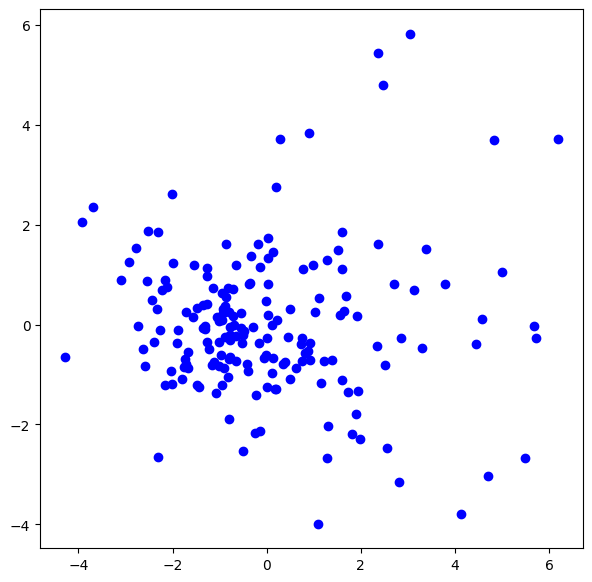

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

for f in df_to_draw.iterrows():
    ax.scatter(f[1]['pca1'], f[1]['pca2'], color = 'blue')

plt.show()

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_clean)

In [ ]:
model = PCA(n_components=3)
model.fit(df_scaled)
df_pca_3 = model.transform(df_scaled)

In [ ]:
def draw_3d(data):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')

    for f in data:
        ax.scatter(f[0], f[1], f[2], c='b')
    plt.show()

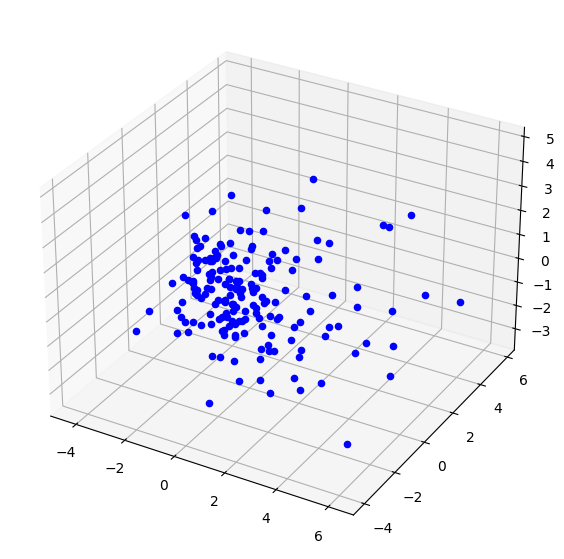

In [ ]:
draw_3d(df_pca_3)